# 네이버 영화 리뷰 감성 분류하기(7~10)
#### 고려대학교 컴퓨터정보통신대학원 빅데이터융합학과   2019512014 이동환


In [46]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 1. 데이터 로드

In [47]:
## 1차 데이터셋 확인
# new
# 긍정(1) 7~10 / 부정(0) : 1~4

# Total
total_data = pd.read_csv('./[데이터셋1차_2_Total] nsmc_raw_data.csv')

# Training Set
train_data = pd.read_csv('./[데이터셋1차_2_Training_Set] nsmc_raw_data.csv')

# Test Set
test_data = pd.read_csv('./[데이터셋1차_2_Test_Set] nsmc_raw_data.csv')
#data = data[['review_id', 'review', 'label', 'rating']]

train_data.head(5)

# 긍정
#data[data.label == 1]

# 부정
#data[data.label == 0]

,label,rating,review,review_id,seq,temp
0,1,7,그냥그래요~그냥그래여..,9312820,1,Training_Set
1,1,10,윈터솔져에서 열연했던 엘리자베스가 출연해서 깜짝 놀랐네요 허허 다코타패닝은 아이에서...,9320675,2,Training_Set
2,0,3,너무기대하고봐서그런가 실망,9322458,1,Training_Set
3,1,8,그럭저럭 무난하게 볼만한 영화인것 같아요~,9323156,3,Training_Set
4,1,7,그냥 흔한 10대소녀들 사랑이야기. 솔직히 엘리자베스 올슨 때문에 봤다.,9325823,4,Training_Set


In [48]:
# 각 데이터 셋의 크기
print("Total_Set : ", len(total_data))
print("Training_Set : ", len(train_data))
print("Test_Set : ", len(test_data))

Total_Set :  639101
Training_Set :  447369
Test_Set :  191732


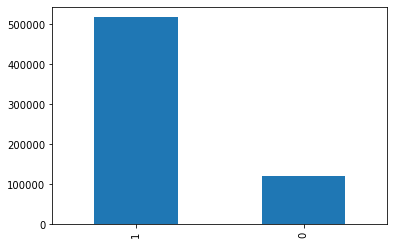

In [49]:
# 전체 데이터 셋의 긍부정 비
total_data['label'].value_counts().plot(kind = 'bar')

In [50]:
# 전체 데이터 셋의 긍부정 수
print(total_data.groupby('label').size().reset_index(name = 'count'))

   label   count
0      0  121684
1      1  517417


### 2. 데이터 정제 및 전처리
-> Training_Set과 마찬가지로 Test_Set에도 동일한 전처리 적용

### 2-1. 데이터 중복 확인

In [51]:
# 데이터 중복 확인
train_data['review'].nunique(), train_data['label'].nunique()
test_data['review'].nunique(), train_data['label'].nunique()

(187997, 2)

In [52]:
# reveiw 열에서 중복인 내용이 있다면 중복 제거
train_data.drop_duplicates(subset=['review'], inplace=True)
test_data.drop_duplicates(subset=['review'], inplace=True)

In [53]:
print('총 샘플의 수(Training_Set) :',len(train_data))
print('총 샘플의 수(Test_Set) :',len(test_data))

총 샘플의 수(Training_Set) : 431352
총 샘플의 수(Test_Set) : 187998


### 2-2. 데이터 Null 값 처리

In [54]:
# Null 값 존재 확인
print(train_data.isnull().values.any())
print(test_data.isnull().values.any())

# True 결과가 나왔다면 데이터 중에 Null 값을 가진 샘플이 존재한다는 의미

True
True


In [55]:
# Null 값을 갖는 샘플수 확인
print(train_data.isnull().sum())
print(test_data.isnull().sum())

label        0
rating       0
review       1
review_id    0
seq          0
temp         0
dtype: int64
label        0
rating       0
review       1
review_id    0
seq          0
temp         0
dtype: int64


In [56]:
# Null 값을 갖는 샘플의 열/인덱스 등 확인
train_data.loc[train_data.review.isnull()]
test_data.loc[test_data.review.isnull()]

,label,rating,review,review_id,seq,temp
2909,0,1,NaN,1034280,88088,Test_Set


In [57]:
# Null 값을 갖는 샘플 제거
train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any')

In [58]:
# Null 값이 존재하는지 확인
print(train_data.isnull().values.any())
print(test_data.isnull().values.any())

False
False


### 2-3. 데이터 전처리

In [59]:
#(예시)알파벳과 공백을 제외하고 모두 제거
text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
re.sub(r'[^a-zA-Z ]', '', text)

'do you expect people to read the FAQ etc and actually accept hard atheism'

In [60]:
# 한글과 공백을 제외하고 모두 제거
train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

train_data[:5]
test_data[:5]

,label,rating,review,review_id,seq,temp
0,0,4,희망적인영화였습니다,5285310,85179,Test_Set
1,0,1,내용도 제목도 어이없음 중국어 배우신 분들은 알겠지만 동화처럼 보이려고 제목 바꿈,5340615,85180,Test_Set
2,0,1,촌장 없애버리고 싶다,5425935,85181,Test_Set
3,0,1,정말 같은 내용의 만화이다역시 초등학교만 졸업하면 얼마나 대가리가 같고 지멋대로이...,7520119,85182,Test_Set
4,0,1,재미는잇는데 여주 방송할때 암말안하고 주둥이반씰룩거릴때 아구창꽂아버리고싶엇음,7520226,85183,Test_Set


In [61]:
# 전처리 후 Null값 확인
train_data['review'].replace('', np.nan, inplace=True)
test_data['review'].replace('', np.nan, inplace=True)

print(train_data.isnull().sum())
print(test_data.isnull().sum())

label          0
rating         0
review       906
review_id      0
seq            0
temp           0
dtype: int64
label          0
rating         0
review       393
review_id      0
seq            0
temp           0
dtype: int64


In [62]:
# 전처리 후 Null값 제거
train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any')

print(len(train_data))
print(len(test_data))

430445
187604


### 3. 토큰화
-> 토큰화를 위한 형태소 분석기는 KoNLPy의 Okt 사용

In [63]:
# 불용어(StopWord) 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','오','좀']

In [64]:
# 형태소 분석기를 사용하여 토큰화를 진행 및 불용어 제거한 데이터를 x_train 에 저장
okt = Okt()
X_train = []
for sentence in train_data['review']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)    

In [65]:
print(X_train[:3])

[['그냥', '그', '래', '요', '그냥', '그렇다'], ['윈터', '솔져', '에서', '열연', '엘리자베스', '출연', '깜짝', '놀라다', '허허', '다코타', '패닝', '아이', '에서', '소녀', '되다', '듯', '느낌', '물씬', '풍기', '고', '이제', '진정하다', '주연', '배우', '로서', '거듭', '날', '수', '있다', '않다', '생각', '보다', '첫사랑', '아련하다', '추억', '더불다', '우정', '의미', '그린', '영화', '강력', '추천'], ['너무', '기대하다', '보다', '그', '런가', '실망']]


In [66]:
# 형태소 분석기를 사용하여 토큰화를 진행 및 불용어 제거한 데이터를 x_test 에 저장
X_test = []
for sentence in test_data['review']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [67]:
print(X_test[:3])

[['희망', '적', '인', '영화', '이다'], ['내용', '제목', '어이없다', '중국어', '배우다', '분', '알다', '동화', '처럼', '보이다', '제목', '바꿈'], ['촌장', '없애다', '버리다', '싶다']]


### 4. 정수 인코딩

In [ ]:
### 4. 정수 인코딩

In [68]:
# 단어 집합 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

#print(tokenizer.word_index)

In [69]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 66122
등장 빈도가 2번 이하인 희귀 단어의 수: 35973
단어 집합에서 희귀 단어의 비율: 54.40398052085539
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.9469384601762844


In [70]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 30151


In [71]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print(X_train[:3])

[[58, 28, 811, 52, 58, 72], [11458, 12288, 18, 1552, 4356, 562, 1665, 451, 2899, 4486, 3304, 239, 18, 881, 13, 100, 87, 3009, 11865, 55, 333, 569, 623, 50, 997, 2810, 488, 49, 6, 17, 26, 3, 1437, 991, 408, 1512, 1032, 324, 1063, 2, 2053, 193], [10, 311, 3, 28, 985, 462]]


In [72]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

### 5. 빈 샘플(empty samples) 제거

In [73]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [74]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

429063
429063


### 6. 패딩

리뷰의 최대 길이 : 70
리뷰의 평균 길이 : 10.739700230502281


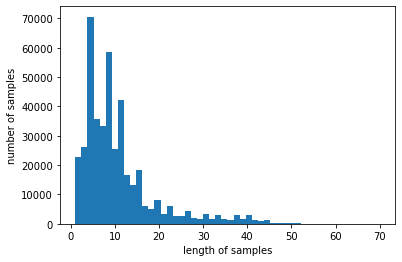

In [75]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [76]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [77]:
max_len = 35
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 35 이하인 샘플의 비율: 96.62683568613467


In [78]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### 7. LSTM으로 감성 분류

In [79]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [81]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

In [82]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [83]:
print(X_train)
print(y_train)
print(y_test)

[[   0    0    0 ...   52   58   72]
 [ 451 2899 4486 ...    2 2053  193]
 [   0    0    0 ...   28  985  462]
 ...
 [   0    0    0 ...   27    2  705]
 [   0    0    0 ... 1142  556   30]
 [   0    0    0 ... 1832   11    7]]
[1 1 0 ... 1 1 1]
[0 0 0 ... 1 1 1]


In [85]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

5863/5863 [==============================] - 26s 4ms/step - loss: 0.2748 - acc: 0.8875

 테스트 정확도: 0.8875


In [116]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    result = 0
    if(score > 0.5):
        #print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
        result = 1
    else:
        #print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))
        result = 0
    
    return result

In [131]:
eval_data = pd.read_csv('./[전처리]ko_data.csv')
eval_data['Predicted'] = 0

for i in range(len(eval_data)):
    Predicted = sentiment_predict(eval_data['Sentence'][i])
    eval_data['Predicted'][i] = Predicted
    
eval_data.to_csv("result.csv", index=False)

<ipython-input-131-5bff6fe11ee8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_data['Predicted'][i] = Predicted
